# Unsupervised learning Clustering K-Means 

In this project we will implement K-Means clustering method to cluster customers of an airline company to give insights to the airline company

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import datetime as dt

In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Collection

In [ ]:
data = pd.read_csv('flight (1).csv')
data = data.dropna()
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
5,56972,2/10/2008,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,3/31/2014,...,76946.0,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15


# Data Understanding

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58255 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          58255 non-null  int64  
 1   FFP_DATE           58255 non-null  object 
 2   FIRST_FLIGHT_DATE  58255 non-null  object 
 3   GENDER             58255 non-null  object 
 4   FFP_TIER           58255 non-null  int64  
 5   WORK_CITY          58255 non-null  object 
 6   WORK_PROVINCE      58255 non-null  object 
 7   WORK_COUNTRY       58255 non-null  object 
 8   AGE                58255 non-null  float64
 9   LOAD_TIME          58255 non-null  object 
 10  FLIGHT_COUNT       58255 non-null  int64  
 11  BP_SUM             58255 non-null  int64  
 12  SUM_YR_1           58255 non-null  float64
 13  SUM_YR_2           58255 non-null  float64
 14  SEG_KM_SUM         58255 non-null  int64  
 15  LAST_FLIGHT_DATE   58255 non-null  object 
 16  LAST_TO_END        582

# Data Preprocessing

## Check Null and Missing Values

In [ ]:
data_null = data.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage


## Duplicate Values

In [ ]:
data.duplicated().sum()

0

## Statistical Summary

In [ ]:
data.describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000
mean,31545.754854,4.104849,42.228736,12.067634,11066.303682,5366.827963,5694.530650,17353.000910,171.255309,67.937285,167.349206,0.328384,0.720627,12742.648820,2.820548
std,18187.496028,0.378182,9.761965,14.236472,16283.209178,8103.595049,8710.724917,20969.886756,180.560120,77.449058,122.890446,1.148485,0.183895,20606.104272,7.500252
min,3.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15787.500000,4.000000,35.000000,3.000000,2608.000000,1016.000000,846.000000,4904.000000,28.000000,23.700000,81.000000,0.000000,0.612155,2872.500000,0.000000
50%,31603.000000,4.000000,41.000000,7.000000,5832.000000,2808.000000,2846.000000,10237.000000,104.000000,44.833333,144.000000,0.000000,0.711468,6487.000000,0.000000
75%,47315.500000,4.000000,48.000000,15.000000,13022.000000,6591.500000,6958.000000,21571.500000,258.000000,82.000000,228.000000,0.000000,0.808159,14527.000000,1.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


In [ ]:
data = data.drop('MEMBER_NO', axis=1)

## Numeric Distribution and outlier

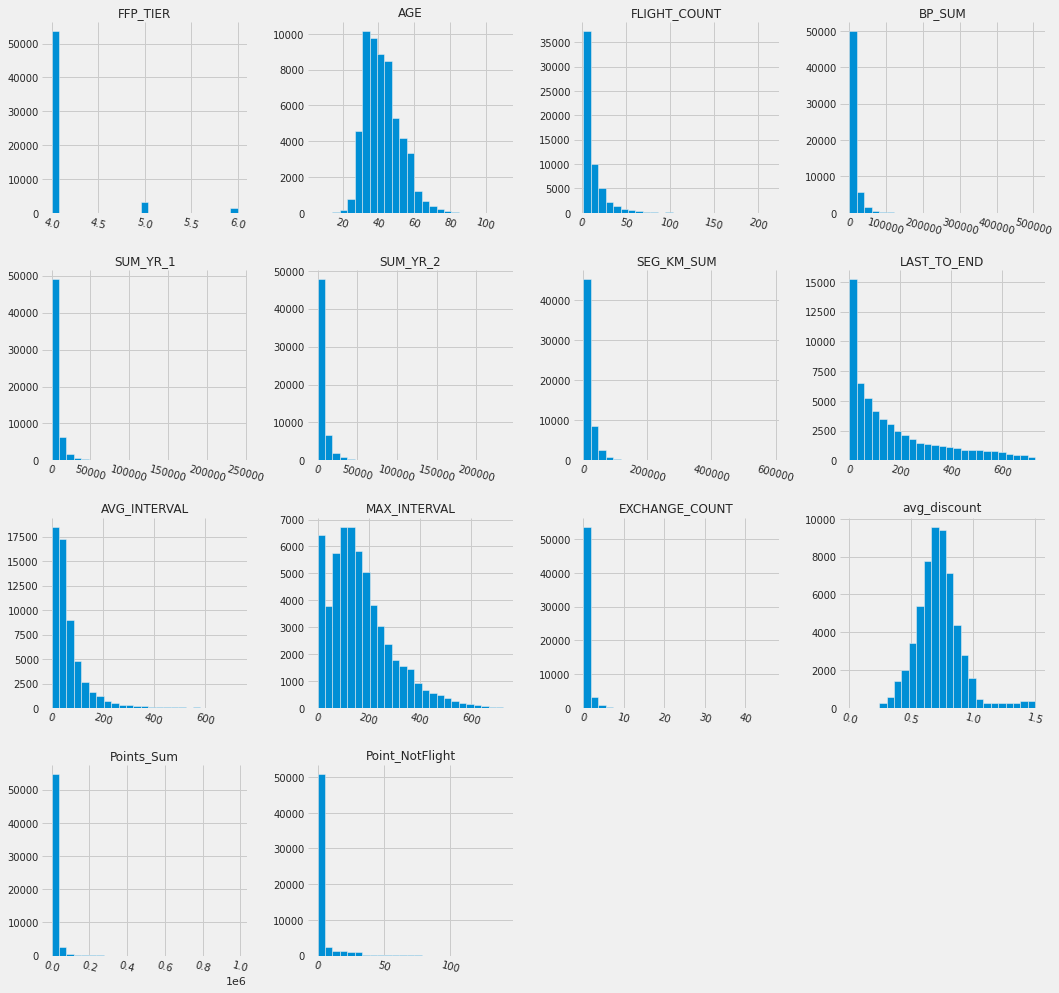

In [ ]:
h = data.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [ ]:
feat_num = ['FFP_TIER','AGE', 'FLIGHT_COUNT','BP_SUM','SUM_YR_1','SUM_YR_2','SEG_KM_SUM','LAST_TO_END','AVG_INTERVAL','MAX_INTERVAL','EXCHANGE_COUNT','avg_discount','Points_Sum','Point_NotFlight']
feat_cat = ['FFP_DATE','FIRST_FLIGHT_DATE','GENDER','WORK_CITY','WORK_PROVINCE','WORK_COUNTRY','LOAD_TIME','LAST_FLIGHT_DATE']

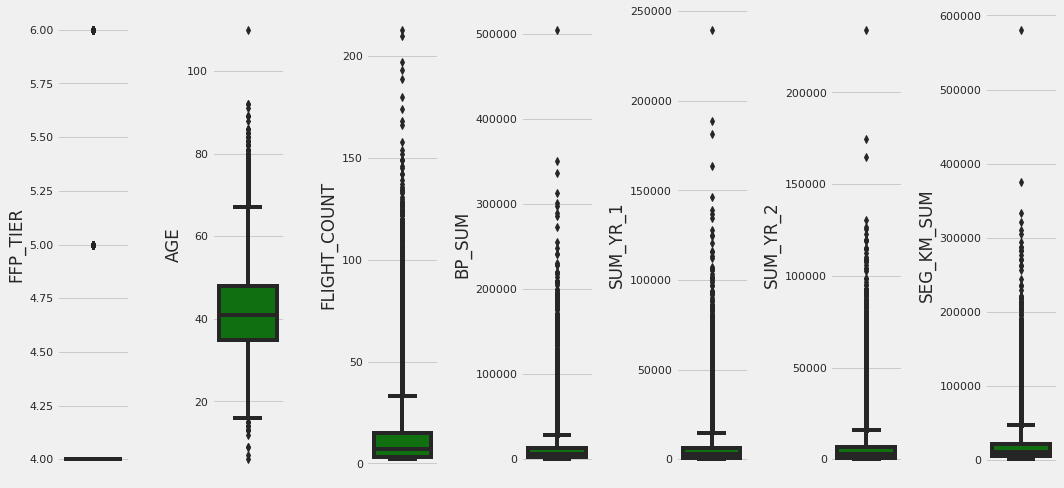

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    if i <= 6:
      plt.subplot(1, 7, i+1)
      sns.boxplot(y=data[feat_num[i]],color='green',orient='v')
      plt.tight_layout()

    

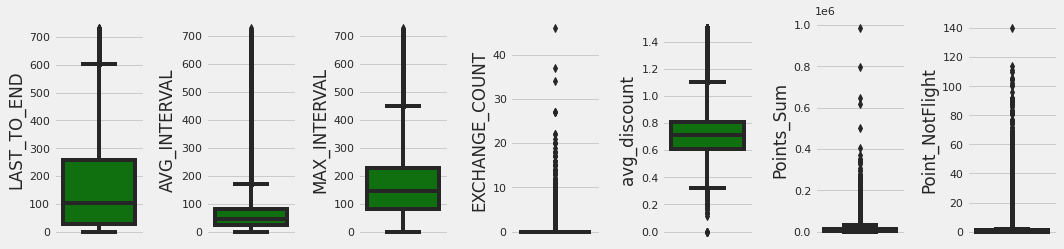

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    if i > 6:
      plt.subplot(2, 7, i+1)
      sns.boxplot(y=data[feat_num[i]],color='green',orient='v')
      plt.tight_layout()


Analisys of numerical features:
1. Unfortunately most of our numerical features does not show a normal distribution and had many outliers so we need to identify and handle one by one
2. FFP_Tier no need to handle because the result is normal for this feature
3. AGE there are a lot of outlier in this dataset but one outlier is exceptionally not logical  (age 110 year), we decide to remove this 
4. FLIGHT_COUNT looks like no issue on the outlier it is still reasonable
5. BP_SUM outlier with value 505308 is too extreme we need to clear this
6. SUM_YR_1, SUM_YR_2, SEG_KM_SUM seems like linearly corelated therefore once we remove outlier in BP_SUM the extreme outlier in this features removed also
7. remove records with ticket price being 0, or average discount being 0 (100% off) SUM_YR_1, SUM_YR_2, avg_discount
8. Other Features looks realistic no need to remove anymore

In [ ]:
data = data[data['AGE'] != 110]
data.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000,58254.000000
mean,4.104851,42.227572,12.067721,11066.306623,5366.815086,5694.578827,17353.057558,171.252051,67.937587,167.348405,0.328372,0.720626,12742.675404,2.820545
std,0.378185,9.758010,14.236579,16283.348925,8103.664008,8710.791921,20970.062287,180.559958,77.449688,122.891349,1.148491,0.183896,20606.280139,7.500317
min,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,35.000000,3.000000,2608.000000,1016.000000,846.000000,4904.000000,28.000000,23.700000,81.000000,0.000000,0.612148,2872.250000,0.000000
50%,4.000000,41.000000,7.000000,5832.000000,2808.000000,2846.000000,10236.500000,104.000000,44.825758,144.000000,0.000000,0.711460,6487.000000,0.000000
75%,4.000000,48.000000,15.000000,13022.500000,6591.750000,6958.000000,21571.750000,258.000000,82.000000,228.000000,0.000000,0.808159,14527.000000,1.000000
max,6.000000,92.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


In [ ]:
data.loc[data['FLIGHT_COUNT'] == 213]

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
26,2/1/2007,3/23/2007,Male,6,zhanjiang,guangdong,CN,46.0,3/31/2014,213,...,96568.0,187917,3/29/2014,3,3.433962,37,0,1.146355,795398,49


In [ ]:
data = data[data['BP_SUM'] != 505308]


In [ ]:
data = data[data['SUM_YR_1'] != 0]
data = data[data['SUM_YR_2'] != 0]
data = data[data['avg_discount'] != 0]

In [ ]:
data.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000
mean,4.142696,42.645570,15.843060,14555.183554,7064.848681,7607.222667,22562.166795,100.539395,75.099711,202.668155,0.458167,0.728996,16691.545273,3.328585
std,0.433518,9.623251,15.825709,18479.689924,9071.557507,9720.643166,23306.994258,97.504584,80.505597,117.405868,1.341386,0.174065,23510.038812,8.250683
min,4.000000,12.000000,2.000000,0.000000,108.000000,153.000000,368.000000,1.000000,1.000000,1.000000,0.000000,0.136017,0.000000,0.000000
25%,4.000000,36.000000,6.000000,4317.000000,1859.750000,1926.000000,8038.750000,19.000000,29.421053,117.000000,0.000000,0.627356,4741.000000,0.000000
50%,4.000000,42.000000,11.000000,8875.000000,4174.000000,4394.000000,15235.000000,68.000000,49.916667,175.000000,0.000000,0.715398,9730.500000,0.000000
75%,4.000000,48.000000,20.000000,17566.000000,8795.000000,9381.000000,28406.000000,158.000000,88.428571,262.000000,0.000000,0.804359,19529.250000,2.000000
max,6.000000,92.000000,213.000000,351159.000000,188926.000000,174895.000000,375074.000000,366.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


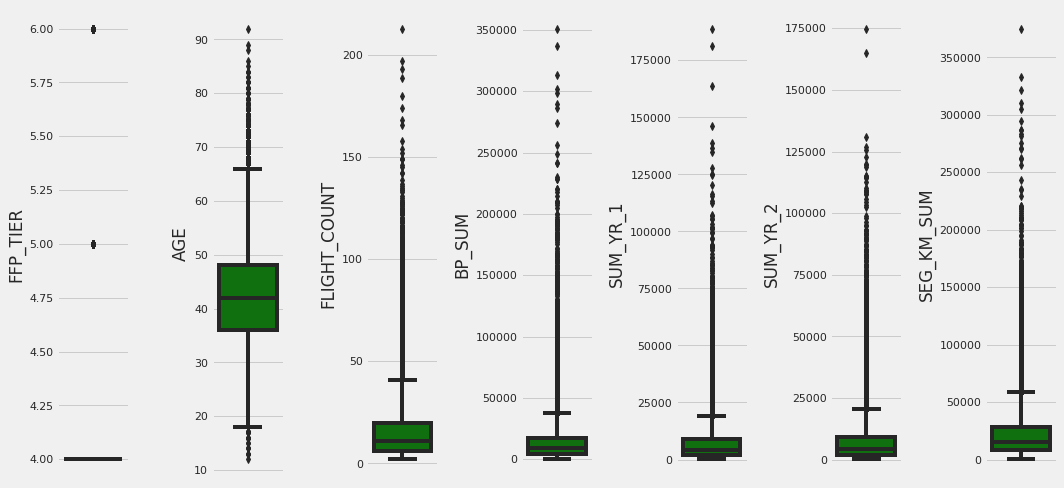

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    if i <= 6:
      plt.subplot(1, 7, i+1)
      sns.boxplot(y=data[feat_num[i]],color='green',orient='v')
      plt.tight_layout()
      

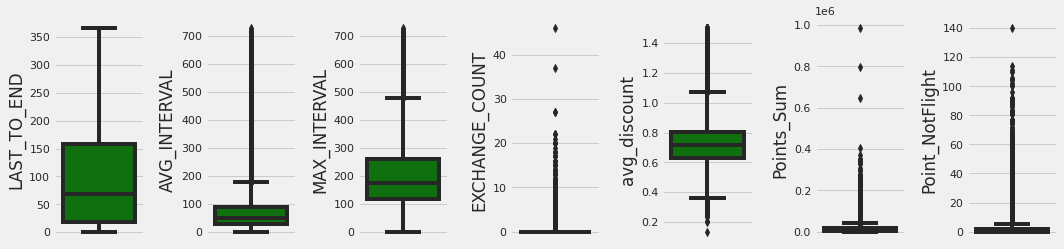

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(0, len(feat_num)):
    if i > 6:
      plt.subplot(2, 7, i+1)
      sns.boxplot(y=data[feat_num[i]],color='green',orient='v')
      plt.tight_layout()


In [ ]:
for col in feat_cat:
  print(f"Value counts of {col} column")
  print(data[col].value_counts(), '\n')

Value counts of FFP_DATE column
1/13/2011     87
9/9/2005      73
1/14/2011     61
11/17/2010    58
1/4/2011      52
              ..
5/18/2009      1
8/23/2005      1
3/7/2005       1
11/9/2004      1
5/3/2009       1
Name: FFP_DATE, Length: 3053, dtype: int64 

Value counts of FIRST_FLIGHT_DATE column
2/16/2013     68
9/9/2005      65
2/15/2013     53
3/23/2013     53
2/28/2013     50
              ..
12/29/2004     1
12/15/2004     1
1/8/2005       1
12/8/2004      1
5/27/2009      1
Name: FIRST_FLIGHT_DATE, Length: 3024, dtype: int64 

Value counts of GENDER column
Male      30524
Female     8440
Name: GENDER, dtype: int64 

Value counts of WORK_CITY column
guangzhou           6664
beijing             5032
shanghai            2639
shenzhen            2346
dalian              1363
                    ... 
BEXLEY                 1
ATTOK                  1
nanchong               1
nanjingjiangning       1
taizhoushi             1
Name: WORK_CITY, Length: 2175, dtype: int64 

Value cou

## Correlation Matrix

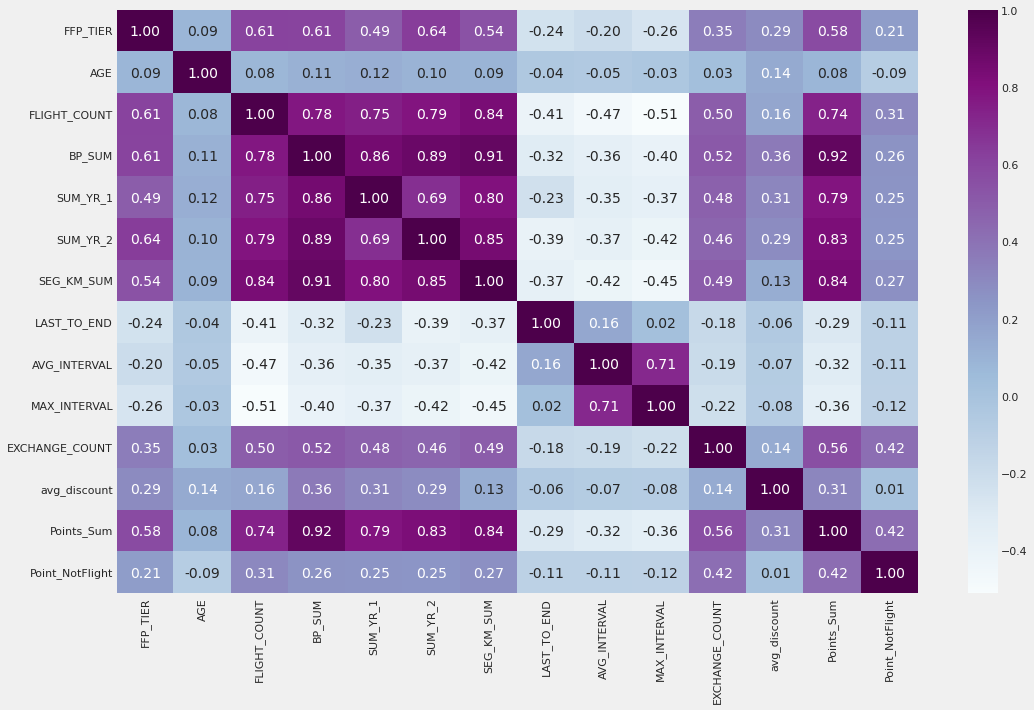

In [ ]:
corr_= data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

Observartion:
1. There are a lot of feature in the dataset and some feature is highly correlated to each other (corr value above 0.8) therefore we need to perform feature selection
2. For unsupervised learning feature selection is different with supervised learning. In this case we will select the features based on LRMFC (Length of customer relationship, Recency, Frequency, Monetary, and Average Discount of Ticket Price). The LRFMC can be translated to the features which is already on the dataset as below.

L = LOAD_DATE - FFP_DATE

R = LAST_TO_END

F = FLIGHT_COUNT

M = SEG_KM_SUM (corelate with ticket prices/ monetary income to the company)

C = avg_discount

In [ ]:
reduce = data[['LOAD_TIME', 'FFP_DATE', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
reduce.head()

,LOAD_TIME,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
2,3/31/2014,2/1/2007,11,135,283712,1.254676
3,3/31/2014,8/22/2008,97,23,281336,1.090870
4,3/31/2014,4/10/2009,5,152,309928,0.970658
5,3/31/2014,2/10/2008,79,92,294585,0.967692
6,3/31/2014,3/22/2006,1,101,287042,0.965347


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
reduce['LOAD_TIME'] = pd.to_datetime(reduce['LOAD_TIME'])
reduce['FFP_DATE'] = pd.to_datetime(reduce['FFP_DATE'])
reduce['L'] = reduce['LOAD_TIME'] - reduce['FFP_DATE']
reduce['L'] = reduce['L'].dt.days


In [ ]:
air_data = reduce[['L', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
air_data_col = ['L','R','F','M','C']
air_data.columns = air_data_col

air_data.head()

,L,R,F,M,C
2,2615,11,135,283712,1.254676
3,2047,97,23,281336,1.090870
4,1816,5,152,309928,0.970658
5,2241,79,92,294585,0.967692
6,2931,1,101,287042,0.965347


In [ ]:
air_data.describe()

,L,R,F,M,C
count,38964.000000,38964.000000,38964.000000,38964.000000,38964.000000
mean,1517.861719,100.539395,15.843060,22562.166795,0.728996
std,851.871726,97.504584,15.825709,23306.994258,0.174065
min,365.000000,1.000000,2.000000,368.000000,0.136017
25%,760.000000,19.000000,6.000000,8038.750000,0.627356
50%,1312.000000,68.000000,11.000000,15235.000000,0.715398
75%,2219.000000,158.000000,20.000000,28406.000000,0.804359
max,3437.000000,366.000000,213.000000,375074.000000,1.500000


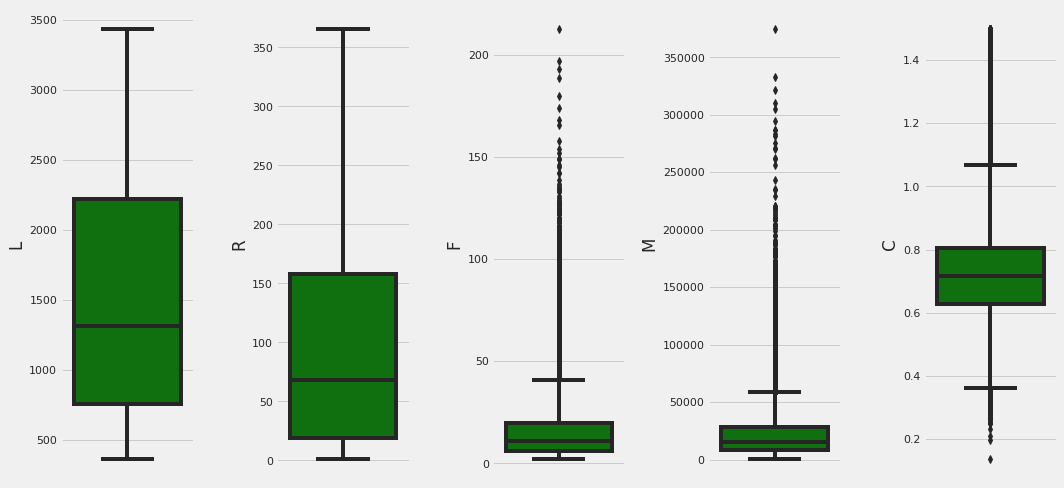

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(0, len(air_data_col)):
      plt.subplot(1, 5, i+1)
      sns.boxplot(y=air_data[air_data_col[i]],color='green',orient='v')
      plt.tight_layout()

## Scaling

In [ ]:
sc_data = StandardScaler()
data_std = sc_data.fit_transform(air_data.astype(float))
df_data_std = pd.DataFrame(data=data_std, columns=air_data_col)

# Evaluate optimal number of cluster

## Inertia

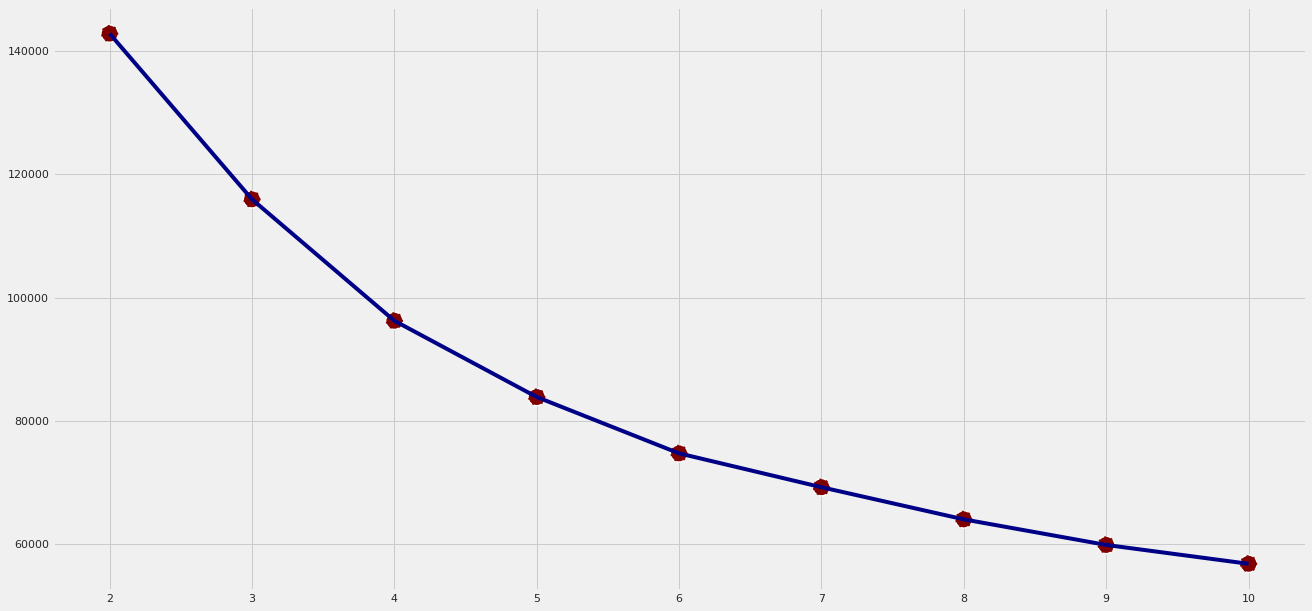

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_data_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))
# plt.plot(inertia)

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')


## Silhouette score

In [ ]:
range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
arr_silhouette_score_mahalanobis = []
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_data_std)
    preds = kmeans.predict(df_data_std)
    
    score_mahalanobis = silhouette_score(df_data_std, preds, metric='mahalanobis')
    arr_silhouette_score_mahalanobis.append(score_mahalanobis)
    
    score_euclidean = silhouette_score(df_data_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

Text(0.5, 1.0, 'Silhouette analysis For Optimal k (Mahalanobis)')

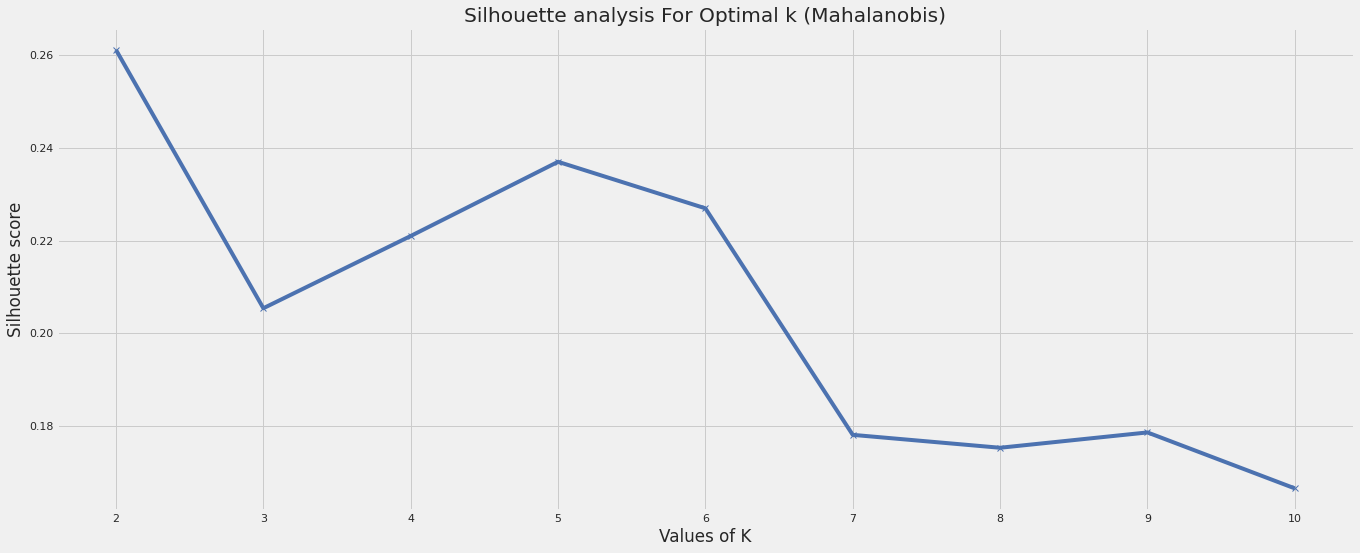

In [ ]:
plt.plot(range_n_clusters,arr_silhouette_score_mahalanobis,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k (Mahalanobis)')

Text(0.5, 1.0, 'Silhouette analysis For Optimal k (Euclidean)')

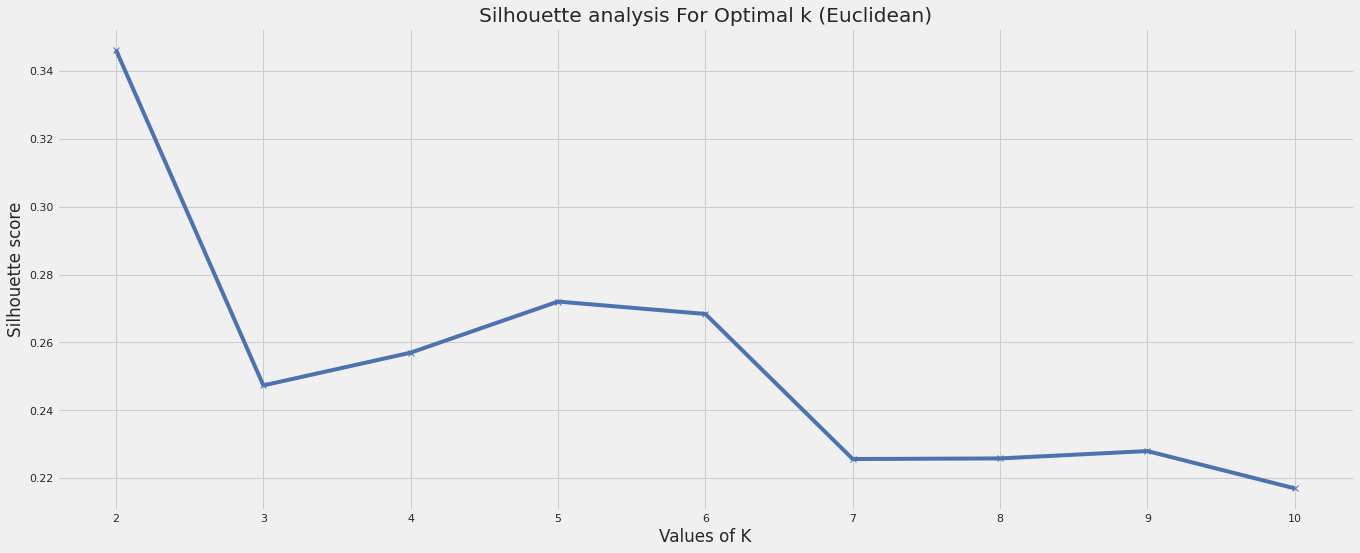

In [ ]:

plt.plot(range_n_clusters,arr_silhouette_score_euclidean,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k (Euclidean)')

Based on elbow and silhoutte method we can expect K = 5 or number of cluster equal to 5 as the most optimized number of cluster

# Modeling

In [ ]:
kmeans = KMeans(n_clusters= 5)
kmeans.fit(df_data_std)
df = pd.DataFrame(kmeans.cluster_centers_,
               index=[0,1,2,3,4],
               columns=['L','R','F','M','C'])
df['count'] = pd.Series(kmeans.labels_).value_counts()  # Number of each clusters
df

,L,R,F,M,C,count
0,1.145265,-0.313065,-0.086229,-0.092232,-0.118566,9948
1,0.500311,-0.808266,2.315260,2.257562,0.253333,3724
2,-0.699797,-0.459929,-0.180105,-0.181894,-0.200369,15003
3,-0.359723,1.525472,-0.586309,-0.554690,-0.187616,8671
4,0.222246,-0.123344,0.011008,0.027878,3.001163,1618


# Insight

we need to transform the dataframe to 2d using principal component

In [ ]:
pca = PCA(n_components=2)

pca.fit(df_data_std)
pcs = pca.transform(df_data_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = kmeans.labels_
data_pca.head()

,PC 1,PC 2,clusters
0,12.555149,0.602727,1
1,7.463202,0.501576,1
2,13.380581,-1.447301,1
3,10.479184,-0.577919,1
4,11.169158,-0.497007,1


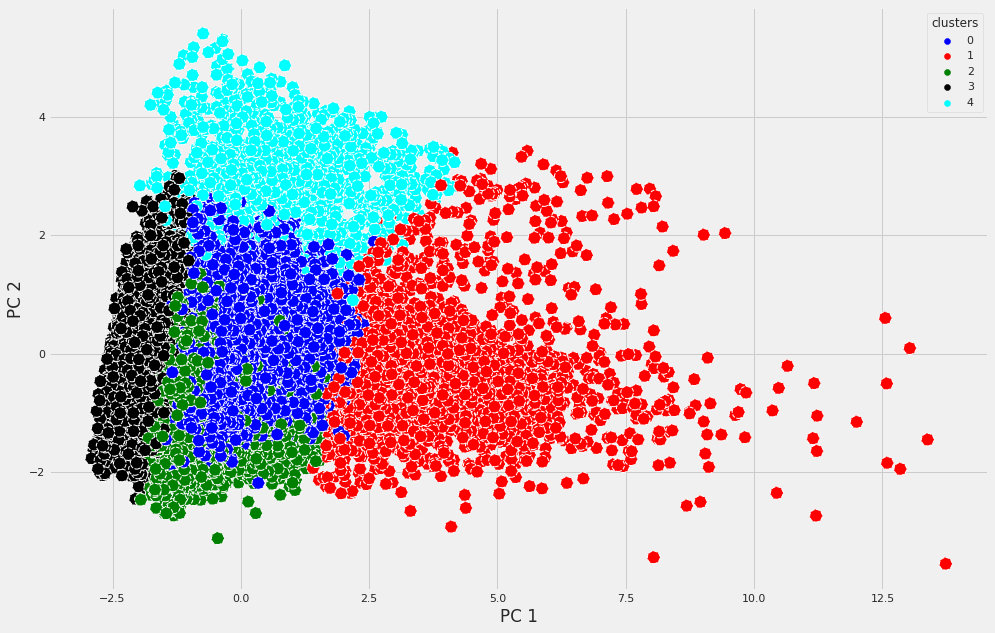

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green','black','cyan'],
    s=160,
    ax=ax
)

In [ ]:
df_data_std['clusters'] = kmeans.labels_
display(df_data_std.groupby('clusters').agg(['mean']))

,L,R,F,M,C
,mean,mean,mean,mean,mean
clusters,,,,,
0,1.145191,-0.312996,-0.086277,-0.092295,-0.118417
1,0.500430,-0.808256,2.315370,2.257497,0.252483
2,-0.699820,-0.459906,-0.180139,-0.181921,-0.200125
3,-0.359601,1.525224,-0.586332,-0.554733,-0.187252
4,0.223454,-0.124611,0.013939,0.031324,3.006124


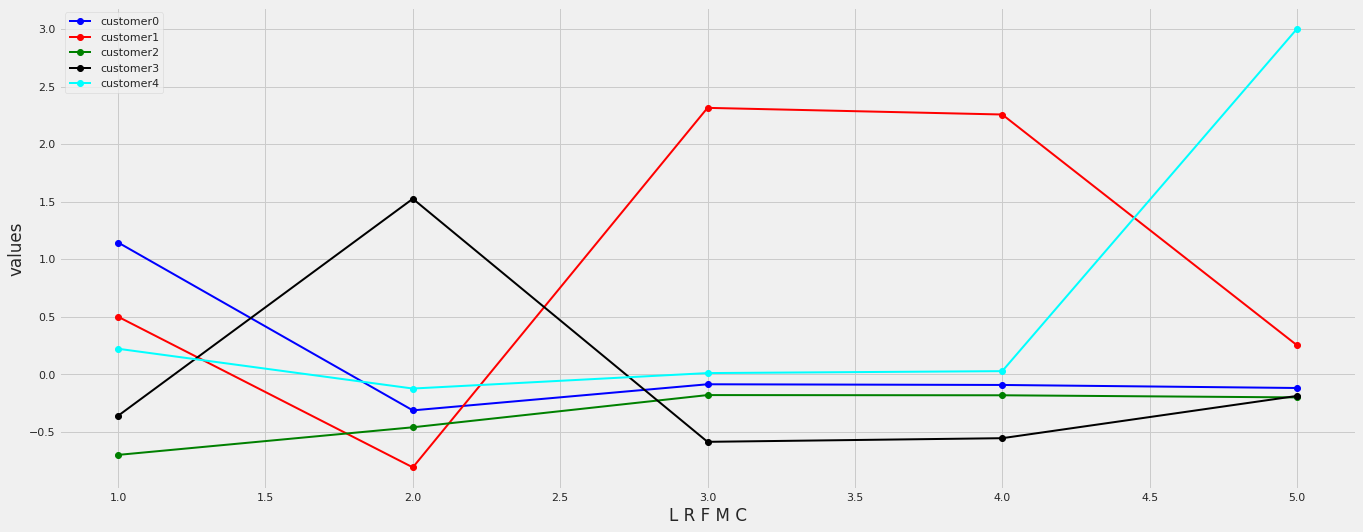

In [ ]:
x=[1,2,3,4,5] # match to L R F M C 
colors=['blue','red','green','black','cyan']
for i in range(5):
    plt.plot(x,kmeans.cluster_centers_[i],label=('customer%d'%(i)),linewidth=2,color=colors[i],marker='o')
    plt.legend()
plt.xlabel('L R F M C')
plt.ylabel('values')
plt.show()

In [ ]:
for i in range(5):
    fig = go.Figure(data=go.Scatterpolar(
      r=kmeans.cluster_centers_[i],
      theta=air_data_col,
      fill='toself',
      fillcolor = colors [i],
      name=('customer%d'%(i))))
    fig.update_layout(
      polar=dict(
      radialaxis=dict(
        visible=True,
        range=[-1, 3]
    )),
    showlegend=True)
    fig.update_traces(marker_opacity=0.5)
    fig.update_traces(line_color=colors[i])
    
    fig.show()


In [ ]:
df

,L,R,F,M,C,count
0,1.145265,-0.313065,-0.086229,-0.092232,-0.118566,9948
1,0.500311,-0.808266,2.315260,2.257562,0.253333,3724
2,-0.699797,-0.459929,-0.180105,-0.181894,-0.200369,15003
3,-0.359723,1.525472,-0.586309,-0.554690,-0.187616,8671
4,0.222246,-0.123344,0.011008,0.027878,3.001163,1618


Customer 3 = Important stable customer: others high except low R (recency). These are the ideal customers with most contribution.

Customer 2 = Important potential customer: others low except high C (average discount received). Current value is not high but has potential to be loyal customer. Although already receive high discount, contribution from these customers is still small. Company need to rethink how to get more contribution from these customers rather than only giving discount.

Customer 0 = Important retain_required customer: others low except high L (relationship duration with company). Uncertain customers need more interaction to extend their flight service life cycle. These customers already have relationship with company for long time but still the contibution is small. Company need to approach these customers with promotion to increase their contribution. 

Customer 4 = General customer: others low except high R (recency). These customers does not use the company service at recent time and not contributing too much to company. Company should focus on how to make these customer come to the company and use company service again to increase the recency of these customers.

Customer 1 = Low_valued customer: all low. These customers used company service recently but still not contributing much to the company (low frequency and monetary). Now the company should focus to maintain the recency and increase the frequency for these customers. 